In [1]:
# Libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import time


## The 2D Heat Equation

The 2D heat equation describes the temperature distribution within a two-dimensional domain. It considers spatial coordinates $x$ and $y$ and time $t$. The general form of the 2D heat equation is:

$$ \frac{∂u}{∂t}​=k(\frac{∂^2u}{∂x^2}​+\frac{∂^2u}{∂y^2}​)$$

where:

- $u(x, y, t)$ represents the temperature distribution at position $(x, y)$ and time $t$.
- $k$ is the thermal diffusivity of the material.

One of the forms to approximate the solution of the heat equation is the Finite Difference Method (FDM). FDM works by dividing the 2D spatial domain into a grid. Each grid point corresponds to a specific spatial location $(x_i, y_j)$. Then, at each grid point, apply the energy balance principle to each grid point, replacing the partial derivatives with finite differences. The resulting finite-difference equation for the 2D heat equation is:

$$ \frac{u_{i,j}^{n+1}​−u_{i,j}^n}{Δt}​​=k(\frac{u_{i+1,j}^n​−2u_{i,j}^n​+u_{i−1,j}^n}{Δx^2}​​+\frac{u_{i,j+1}^n​−2u_{i,j}^n​+u_{i,j−1}^n}{Δy^2}​​)$$

where:

- $u_{i,j}^{n}$ represents the temperature at grid point $(x_i, y_j)$ and time step $n$.
- $\Delta t$ is the time step, $\Delta x$ and $\Delta y$ are the spatial step sizes.

The system is then solved by iteratively updating the temperature values based on the neighbors' values while selecting a small enough time step and specifying the boundary conditions for all domain boundaries. Examples of boundary conditions include fixed-temperature, insulated, or convective boundaries.
The choice of time step affects stability and accuracy.


To improve the display and readability of your text on the 2D Heat Equation, especially for a Jupyter Notebook, you can use Markdown for a structured and clear presentation:


## Example

Let's consider a $1*1$ block of some material with diffusivity of $0.1$ surounded by air at $25°$, with a $100°$ source on the left, and a $50°$ source on the right.

A simplified implementation considering $100*100$ points is shown below but could be more time-efficient.

In [2]:
# Constants
Lx, Ly    = 1.0, 1.0                   # Length of the domain in x and y directions
T_ambient = 25.0                       # Ambient temperature
T_left    = 100.0                      # Temperature at the left end
T_right   = 50.0                       # Temperature at the right end

num_points_x, num_points_y = 100, 100  # Number of points in x and y directions


dx = Lx / (num_points_x - 1)           # Grid spacing in x direction
dy = Ly / (num_points_y - 1)           # Grid spacing in y direction
k  = 0.1                               # Thermal diffusivity


# Simulation parameters
# Feel free to adjust the following parameters as needed

# num_steps = 100_000                    # Number of iteration steps
# dt        = 1e-4                       # Time step

num_steps = 1000
dt        = 1e-4

In [3]:
# Function to update temperature
def update(T: np.array,
           dt: float,
           dx: float,
           dy: float,
           k: float,
           num_points_x: int,
           num_points_y: int
           ):
    """
    Update the temperature distribution using the explicit finite difference method.

    Parameters:
    T: Current temperature distribution.
    dt: Time step size.
    dx: Grid spacing in x direction.
    dy: Grid spacing in y direction.
    k: Thermal diffusivity constant.
    num_points_x: Number of grid points in x direction.
    num_points_y: Number of grid points in y direction.

    Returns:
    np.array: Updated temperature distribution.
    """
    # Compute new temperatures using explicit finite difference method
    T_new = np.copy(T)
    for i in range(1, num_points_x-1):
        for j in range(1, num_points_y-1):
            delta_T = (
                (T[i+1, j] - 2*T[i, j] + T[i-1, j]) / dx**2 +
                (T[i, j+1] - 2*T[i, j] + T[i, j-1]) / dy**2
            )
            T_new[i, j] = T[i, j] + k * dt * delta_T

    # Update
    T = T_new

    return T


def run_fdm(num_steps: int=num_steps,
            dt: float=dt,
            num_points_x: int=num_points_x,
            num_points_y: int=num_points_y
            ):
    """
    Run the finite difference method simulation.

    Parameters:
    num_steps: Number of iteration steps.
    dt: Time step size.
    num_points_x: Number of grid points in x direction.
    num_points_y: Number of grid points in y direction.

    Returns:
    np.array: Final temperature distribution.
    """
    # Initialize temperature array
    T = np.ones((num_points_x, num_points_y)) * T_ambient
    # Set boundary conditions
    T[:, 0]  = T_left   # Left boundary
    T[:, -1] = T_right  # Right boundary

    # Run simulation
    for _ in range(num_steps+1):
        T = update(T, dt, dx, dy, k, num_points_x, num_points_y)

    return T

In [4]:
t0 = time.time()
T = run_fdm(num_steps, dt, num_points_x, num_points_y)
t1 = time.time()

total = t1-t0

print('Numpy takes ' + str(round(total,2)) + ' sec' )

Numpy takes 8.46 sec


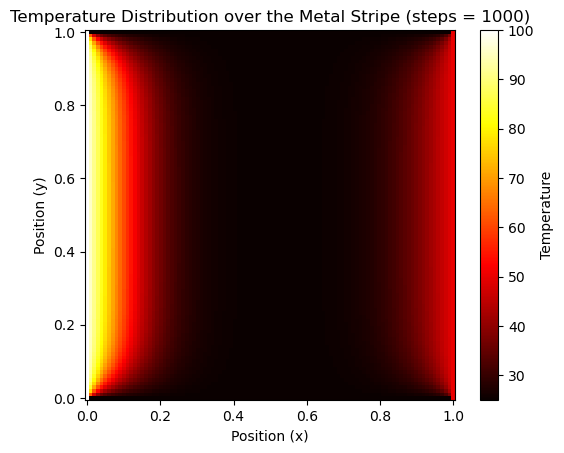

In [5]:
# Create figure
fig, ax = plt.subplots()
img = plt.imshow(T, cmap='hot', origin='lower', extent=[-dx/2, Lx+dx/2, -dy/2, Ly+dy/2])
plt.colorbar(img, label='Temperature')
plt.xlabel('Position (x)')
plt.ylabel('Position (y)')
plt.title('Temperature Distribution over the Metal Stripe (steps = {})'.format(num_steps))
plt.show()

## Optimizing FDM with PyTorch

**Objective:**
Enhance the efficiency of the FDM solution by utilizing PyTorch, especially leveraging GPU capabilities for improved computation speed.

The idea is to rewrite both update and run_fdm functions using PyTorch because we want to leverage GPU acceleration and vectorized operations to optimize performance. The main change is to replace numpy operations with PyTorch tensor operations and use vectorized computations instead of explicit loops。

In [6]:
# Selct device
device = torch.device('cuda' if torch.cuda.is_available() else ('mps' if torch.backends.mps.is_available() else 'cpu'))

In [7]:
device

device(type='mps')

In [8]:
# Function to update temperature using PyTorch and vectorized operations
def update_torch(T: torch.Tensor,
           dt: float,
           dx: float,
           dy: float,
           k: float,
           num_points_x: int,
           num_points_y: int):

    """
    Update the temperature distribution using the explicit finite difference method.

    Parameters:
    T: Current temperature distribution (torch.Tensor).
    dt: Time step size.
    dx: Grid spacing in x direction.
    dy: Grid spacing in y direction.
    k: Thermal diffusivity constant.
    num_points_x: Number of grid points in x direction.
    num_points_y: Number of grid points in y direction.

    Returns:
    torch.Tensor: Updated temperature distribution.
    """
    # Create a new tensor to store the updated temperatures
    T_new = torch.clone(T)

    # Vectorized operations for the finite difference computation
    # Central finite differences in x and y directions
    delta_x = (T[2:, 1:-1] - 2 * T[1:-1, 1:-1] + T[:-2, 1:-1]) / dx**2
    delta_y = (T[1:-1, 2:] - 2 * T[1:-1, 1:-1] + T[1:-1, :-2]) / dy**2

    # Total change in temperature due to thermal diffusivity
    delta_T = delta_x + delta_y

    # Update the interior of the temperature grid
    T_new[1:-1, 1:-1] = T[1:-1, 1:-1] + k * dt * delta_T

    return T_new


def run_fdm_torch(num_steps: int=num_steps,
            dt: float=dt,
            num_points_x: int=num_points_x,
            num_points_y: int=num_points_y,
            device: torch.device=device
            ):
    """
    Run the finite difference method simulation using PyTorch.

    Parameters:
    num_steps: Number of iteration steps.
    dt: Time step size.
    num_points_x: Number of grid points in x direction.
    num_points_y: Number of grid points in y direction.
    device: Computation device (CPU or GPU).

    Returns:
    torch.Tensor: Final temperature distribution.
    """
    # Initialize temperature tensor
     # Initialize temperature array
    T = torch.full((num_points_x, num_points_y), T_ambient, device=device)
    T[:, 0] = T_left  # Left boundary condition
    T[:, -1] = T_right  # Right boundary condition

    # Run the simulation loop
    for _ in range(num_steps):
        T = update_torch(T, dt, dx, dy, k, num_points_x, num_points_y)

    return T


In [9]:
t0 = time.time()
T_torch = run_fdm_torch(num_steps, dt, num_points_x, num_points_y, device)
t1 = time.time()

total = t1-t0

print('Torch takes ' + str(round(total,2)) + ' sec')




Torch takes 0.31 sec


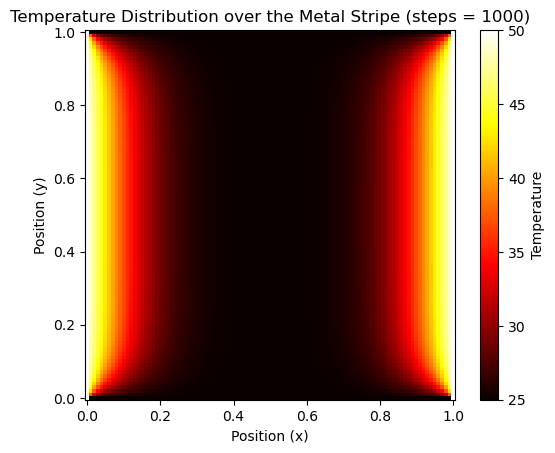

In [10]:
# Convert the final_temperature tensor to a NumPy array for visualization
T_torch_numpy = T_torch.cpu().numpy()

# Create figure
fig, ax = plt.subplots()
img = plt.imshow(T_torch_numpy, cmap='hot', origin='lower', extent=[ -dy/2, Ly+dy/2, -dx/2, Lx+dx/2])
plt.colorbar(img, label='Temperature')
plt.xlabel('Position (x)')
plt.ylabel('Position (y)')
plt.title('Temperature Distribution over the Metal Stripe (steps = {})'.format(num_steps))
plt.show()

## Multiple materials
**Objective:**  
Modify the existing FDM solver to accommodate multiple materials with different thermal diffusivities. Specifically, simulate a scenario with two hot rods facing each other, separated by a material with lower thermal diffusivity e.g., with $k$ of $0.002$.

**Example:**
In a $7*7$ representation, the 2-rods could be:

```python
shape = [
    [ 0 0 0 0 0 0 0 ]
    [ 0 0 0 0 0 0 0 ]
    [ 1 1 1 0 1 1 1 ]
    [ 2 2 1 0 1 2 2 ]
    [ 1 1 1 0 1 1 1 ]
    [ 0 0 0 0 0 0 0 ]
    [ 0 0 0 0 0 0 0 ]]
```

Where:
- 0 identifies low diffusivity
- 1 identifies high diffusivity
- 2 identifies the heat sources
    

In [11]:
# Define a dictionary mapping material types to their thermal diffusivity values
thermal_diffusivity = {
    0: 2e-3,  # Low diffusivity
    1: 0.1,   # High diffusivity
    2: 0.1    # Heat sources
}

# Define material types in the grid
material_grid = torch.tensor([
    [0, 0, 0, 0, 0, 0, 0], 
    [0, 0, 0, 0, 0, 0, 0],
    [1, 1, 1, 0, 1, 1, 1],  
    [2, 2, 1, 0, 1, 2, 2],  
    [1, 1, 1, 0, 1, 1, 1],  
    [0, 0, 0, 0, 0, 0, 0],  
    [0, 0, 0, 0, 0, 0, 0]
], dtype=torch.int)

# Function to update temperature distribution with multiple materials
def update_temperature(T: torch.Tensor,
                        material_grid: torch.Tensor,
                        dt: float,
                        dx: float,
                        dy: float,
                        thermal_diffusivity: dict,
                        num_points_x: int,
                        num_points_y: int):
    """
    Update the temperature distribution with multiple materials using the explicit finite difference method.
    
    Parameters:
    T: Current temperature distribution.
    material_grid: Grid identifying material types.
    dt: Time step size.
    dx: Grid spacing in x direction.
    dy: Grid spacing in y direction.
    thermal_diffusivity: Dictionary mapping material types to their thermal diffusivity.
    num_points_x: Number of grid points in x direction.
    num_points_y: Number of grid points in y direction.
    
    Returns:
    torch.Tensor: Updated temperature distribution.
    """
    
    # Clone the temperature grid to create the new state
    T_new = torch.clone(T)

    # Ensure the loop doesn't exceed bounds of the grid
    max_x = min(num_points_x - 1, material_grid.shape[1] - 1)
    max_y = min(num_points_y - 1, material_grid.shape[0] - 1)

    # Update the temperature using a finite difference method with multiple materials
    for i in range(1, max_x):
        for j in range(1, max_y):
            mat_type = material_grid[i, j]  # Get the material type
            k = thermal_diffusivity.get(mat_type, 0.1)  # Default to high diffusivity if not specified

            # Calculate the finite difference for each material type
            delta_T = (
                (T[i + 1, j] - 2 * T[i, j] + T[i - 1, j]) / dx ** 2 +
                (T[i, j + 1] - 2 * T[i, j] + T[i, j - 1]) / dy ** 2
            )

            # Update temperature using thermal diffusivity and timestep
            T_new[i, j] = T[i, j] + k * dt * delta_T

    return T_new


def run_fdm_multi(num_steps: int,
                  dt: float,
                  dx: float,
                  dy: float,
                  thermal_diffusivity: dict,
                  material_grid: torch.Tensor,
                  T_ambient: float,
                  num_points_x: int,
                  num_points_y: int,
                  device: torch.device):
    """
    Run the finite difference method simulation with multiple materials.

    Parameters:
    num_steps: Number of iteration steps.
    dt: Time step size.
    device: Computation device.
    T_ambient: Ambient temperature.
    T_left: Temperature of the left hot rods.
    T_right: Temperature of the right hot rods.
    """
    # Initialize temperature tensor
    T = torch.full((num_points_y, num_points_x), T_ambient, device=device)

    # Set initial conditions for the hot rods
    # Ensure indices don't exceed grid bounds
    half_y = num_points_y // 2
    left_bound = int(3 * num_points_x // 8)
    right_bound = int(5 * num_points_x // 8)

    # Check bounds for initial condition
    if half_y - 5 >= 0 and half_y + 6 <= num_points_y:
        T[half_y - 5:half_y + 6, 0:left_bound] = T_left
        T[half_y - 5:half_y + 6, right_bound:num_points_x - 1] = T_right

    # Implement the simulation loop
    for _ in range(num_steps):
        T = update_temperature(
            T,
            material_grid,
            dt,
            dx,
            dy,
            thermal_diffusivity,
            num_points_x,
            num_points_y
        )

    return T


In [12]:
T_multi_torch = run_fdm_multi(num_steps,
                                  dt,
                                  dx ,
                                  dy ,
                                  thermal_diffusivity,
                                  material_grid,
                                  T_ambient,
                                  num_points_x,
                                  num_points_y,
                                  device)

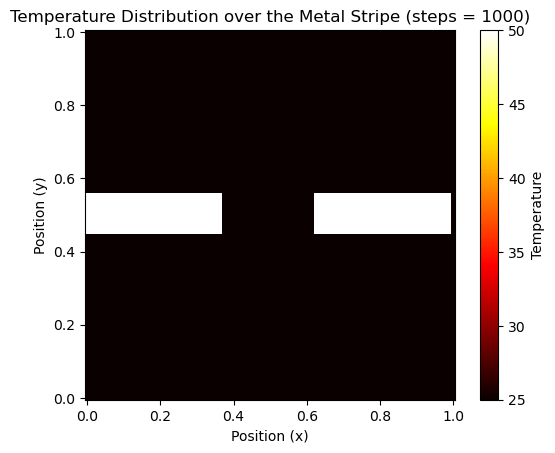

In [13]:

# Convert the final_temperature tensor to a NumPy array for visualization
T_multi_numpy = T_multi_torch.cpu().numpy()

# Create figure
fig, ax = plt.subplots()
img = plt.imshow(T_multi_numpy, cmap='hot', origin='lower', extent=[ -dy/2, Ly+dy/2, -dx/2, Lx+dx/2])
plt.colorbar(img, label='Temperature')
plt.xlabel('Position (x)')
plt.ylabel('Position (y)')
plt.title('Temperature Distribution over the Metal Stripe (steps = {})'.format(num_steps))
plt.show()

## Machine Learning Approach for 2D Heat Equation

**Objective:**
Use a Machine Learning model to approximate the solution of the 2D heat equation at $t = 1$ second.

**Hints:**
1. **Generate Dataset**: Use the FDM solver to create a dataset. Vary conditions such as domain size, temperature, and material properties (if necessary, adjust $t$ to 20ms to expedite execution time).

2. **Model Design and Training**: Develop and train a model to predict temperature distributions.

3. **Model Evaluation**: Assess the model's performance by comparing its predictions with the FDM solutions.

**Requirements:**
- Discuss the reasoning behind the choice of model architecture and the training process.
- Note any simplifications made and their potential impact on the model's performance.

## Step 1: Data Generation: 
 

In [15]:
# Generate a dataset with varying conditions varying initial conditions, boundary conditions, and other properties using finite difference method (FDM) solver define above 

num_samples = 100  # Number of training samples
data = []

for _ in range(num_samples):
    # Randomly modify the left and right temperatures for each sample
    T_left = np.random.uniform(80, 120)  # Random temp between 80 and 120
    T_right = np.random.uniform(180, 220)  # Random temp between 180 and 220

    # Run the FDM solver with the given initial and boundary conditions
    T = run_fdm_torch(num_steps, dt, num_points_x, num_points_y, device)

    # Collect the initial conditions and the final temperature distribution
    initial_conditions = {
        "T_left": T_left,
        "T_right": T_right,
        "T_ambient": T_ambient
    }
    
    data.append((initial_conditions, T))  # Store the initial conditions and final result


## Step 2: Create a Model

Design a simple whose architecture is a simple feedforward neural network with an input layer (representing initial conditions) and an output layer (representing the temperature distribution).

Reasons why to choose SimpleMLP (Simple Multi-Layer Perceptron) model: 

- SimpleMLP uses a feedforward design with a few hidden layers, 
- SimpleMLP is easier to train and less prone to overfitting compared to more complex architectures.
- SimpleMLP requires less computational resources and takes less time to train and run. 
- We want to predict temperature distributions based on initial conditions, which is a regression problem. SimpleMLP is well-suited for a regression problem because it can approximate complex functions through a series of linear transformations and nonlinear activations.
- SimpleMLP can serve as a baseline model to evaluate the performance of more complex architectures. If a simpler model performs well, it can be a preferred choice for many applications. If it underperforms, you can use it as a stepping stone to explore more complex models, like adding more hidden layers, using dropout, or experimenting with different activation functions.

Given these reasons, using a SimpleMLP model provides a good balance between simplicity and performance. However, if the problem complexity increases, or if you have a large dataset, you can consider more complex architectures or add enhancements to the SimpleMLP model, such as additional hidden layers or dropout for regularization.

In [16]:

class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(3, 50)  # 3 input features (T_left, T_right, T_ambient),  50 output features or the number of neurons in the first fully connected (linear) layer.
        self.fc2 = nn.Linear(50, num_points_x*num_points_y)  # (num_points_x by num_points_y) output features (num_points_x by num_points_y grid flattened)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return x

# Create the model
model = SimpleMLP()


## Step 3: Train the Model

The model is trained using mean squared error (MSE) and evaluated using a train-test split. The test loss provides an indication of the model's performance.


In [17]:
# Prepare data for training
X = []
y = []

for sample in data:
    initial_conditions = sample[0]
    final_temperature = sample[1]
    
    # Extract input features
    X.append([initial_conditions["T_left"], initial_conditions["T_right"], initial_conditions["T_ambient"]])
    
    # Extract output features
    y.append(final_temperature.flatten().tolist())  # Flatten to 1D array

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

# Split data into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 100
training_losses = []

for epoch in range(num_epochs):
    # Forward pass
    predictions = model(X_train)
    
    # Compute loss
    loss = criterion(predictions, y_train)
    
    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Store the loss for visualization
    training_losses.append(loss.item())
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{num_epochs} - Loss: {loss.item()}")



Epoch 0/100 - Loss: 5140.630859375
Epoch 10/100 - Loss: 4406.0791015625
Epoch 20/100 - Loss: 3856.56005859375
Epoch 30/100 - Loss: 3447.0947265625
Epoch 40/100 - Loss: 3155.80810546875
Epoch 50/100 - Loss: 2963.51513671875
Epoch 60/100 - Loss: 2846.182373046875
Epoch 70/100 - Loss: 2781.345947265625
Epoch 80/100 - Loss: 2746.1513671875
Epoch 90/100 - Loss: 2725.9560546875


## Step 4: Test the Model and Evaluate Performance
# Test the model on the validation set and visualize the results.

Test Loss: 2729.331787109375


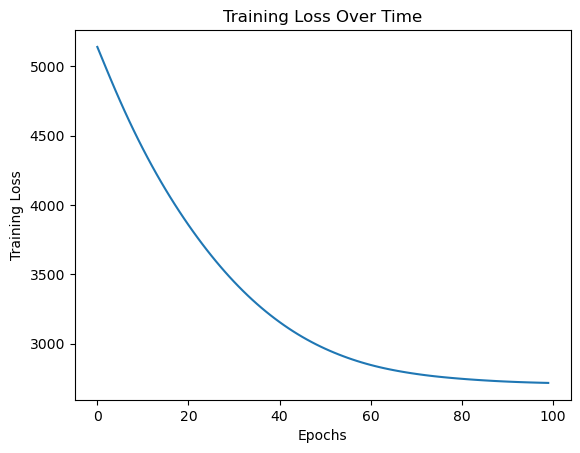

In [18]:

test_predictions = model(X_test)
test_loss = criterion(test_predictions, y_test)
print(f"Test Loss: {test_loss.item()}")

# Plot the training loss over epochs to visualize convergence
plt.plot(training_losses)
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.title("Training Loss Over Time")
plt.show()


## Step 5: Visualize Predictions

Plot actual vs. predicted temperature distributions for evaluation.


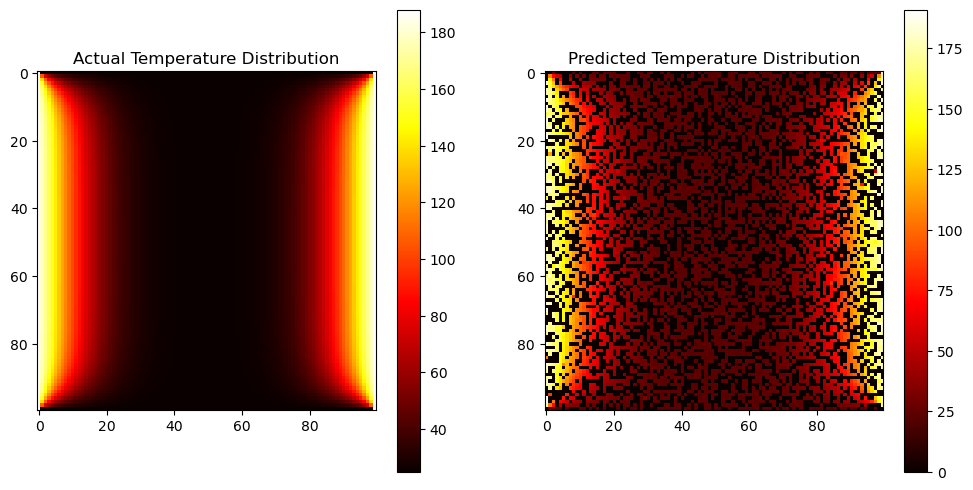

In [19]:

# Choose an example from the test set
example_idx = 0
actual_temp = y_test[example_idx].reshape(num_points_y, num_points_x)
predicted_temp = test_predictions[example_idx].detach().numpy().reshape(num_points_y, num_points_x)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Actual Temperature Distribution")
plt.imshow(actual_temp, cmap="hot", interpolation="nearest")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title("Predicted Temperature Distribution")
plt.imshow(predicted_temp, cmap="hot", interpolation="nearest")
plt.colorbar()

plt.show()


## Conclusion: 
- The training loss decreases epoch increases.
- My solution uses a simple model with minimal layers. It doesn't consider more complex interactions or neural network architectures, which might impact accuracy and generalization.
- We can increase the complexity of the model, use different network architectures, or employ data augmentation might improve accuracy.

## Cloud Deployment Strategy

**Objective:**
Outline a step-by-step method to provide the ML model developed earlier, as a cloud service.

**Requirements:**
- Justify the technology choices behind your solution.
- Outline the deployment step, including the environment setup, ressource allocation, etc.
- Describe how you would manage computation demands in order to minimize operational costs caused by idle times. In other words, describe how you would optimize cloud resources for cost-efficiency.
- Explain your approach for scalability.
- Address how would you handle customer data privacy and access controls.

*If possible, implement a practical prototype. This prototype will serve as a proof-of-concept, which aims to demonstrate key aspects of your deployment strategy.*


## Deploy an ML model developed earlier to the cloud, in particular, Azure, as the cloud platform:

### Step 1: Choose the Deployment Platform
Azure is my choice for deploying cloud services due to its flexibility, scalability, and integration with various ML and AI tools. And, I'm very familiar with and I use daily. 

### Step 2: Prepare the ML Model for Deployment
Previously, we have built the ML model. We need to save the model in a format suitable for cloud-based services. The most common formats are `ONNX` and `PyTorch` state dictionaries. Use the following code to serialize the ML model to a file. 
  
```python
import torch
model = MyMLModel()  # Replace with your model
torch.save(model.state_dict(), "model.pth")
```

### Step 3: Select the Deployment Service
Azure offers multiple deployment options. Given the goal to minimize idle times and optimize for cost-efficiency, let's consider Azure containers or Azure Kubernetes service because they are ideal for continuous workloads or when specific dependencies are needed. 

### Step 4: Environment Setup and Resource Allocation for Azure Container Instances/Kubernetes Service
  - Create a Docker container with the necessary environment.
  - Deploy the container to Azure.
  - Configure resource allocation, including CPU and memory limits.

### Step 5: Implement the Containerized Service
  - Create a simple REST API using frameworks like Flask or FastAPI.
  - Build a Docker image with the necessary dependencies.
  
```bash
# Dockerfile
FROM python:3.9
COPY requirements.txt .
RUN pip install -r requirements.txt
COPY . /app
WORKDIR /app
CMD ["python", "server.py"]  # server.py is your REST API script
```

### Step 6: Test and Deploy the Service

  - Test the container on your local machine to ensure it runs without errors.
  - Push the Docker image to Azure Container Registry and deploy to Azure Container Instances or Azure Kubernetes Service.
  
### Step 7: Implement Cost-Efficiency Measures
To manage computation demands and minimize operational costs, consider the following strategies:

- **Auto-Scaling**:
  - Configure automatic scaling based on demand.
  - Set up Horizontal Pod Autoscaler in Azure Kubernetes Service or similar mechanisms in Azure Container Instances.
  
- **Resource Allocation**:
  - Optimize resource allocation by setting appropriate CPU and memory limits.
  - Use lower-cost instances or serverless options for reduced idle-time costs.
  
### Step 8: Ensure Scalability

- Use Azure Load Balancer or Application Gateway to distribute traffic across instances.

  
### Step 9: Address Security and Privacy

- **Authentication and Authorization**:
  - Implement authentication (e.g., Azure AD, OAuth) to restrict access to the cloud service.
  
- **Data Security**:
  - Ensure data is encrypted in transit using HTTPS.
  - Store sensitive information in Azure Key Vault to manage access securely.
  